In [1]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"


In [2]:
from pathlib import Path
import requests

In [3]:
data_path = Path("data")
path = data_path / 'mnist'

In [4]:
path.mkdir(parents=True, exist_ok=True)

In [5]:
if not (path / FILENAME).exists():
    resp = requests.get(URL + FILENAME)
    content = resp.content
    (path / FILENAME).open('wb').write(content)

In [6]:
!ls data/mnist

mnist.pkl.gz


In [7]:
import pickle
import gzip

with gzip.open((path / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

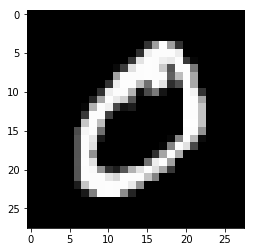

In [10]:
plt.imshow(x_train[1].reshape(28, 28), cmap='gray')

In [11]:
import torch
x_train, y_train, x_valid, y_valid = map(torch.Tensor, (x_train, y_train, x_valid, y_valid))
print(y_train.min())
print(y_train.max())

tensor(0.)
tensor(9.)


initializing the `weights` and `bias` for the nn

In [12]:
weights = torch.randn(784, 10) / (784**0.5)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [13]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    
def model(xb):
    return log_softmax(xb @ weights + bias)

`@` is matrix multiply 

In [14]:
bs = 64
xb = x_train[:bs]
preds = model(xb)
print(preds.shape)
print(preds[0])

torch.Size([64, 10])
tensor([-2.2937, -2.4623, -2.7081, -2.1372, -2.6055, -2.4156, -2.2089, -2.8147,
        -2.2886, -1.6353], grad_fn=<SelectBackward>)


In [15]:
((xb @ weights) + bias).exp().sum(1).log().unsqueeze(-1).shape

torch.Size([64, 1])

In [16]:
((xb @ weights) + bias).shape

torch.Size([64, 10])

In [17]:
yb = y_train[:64]

In [18]:
yb.shape[0]

64

In [19]:
def negative_log_likelihood(preds, target):
    return -preds[range(target.shape[0]), target.long()].mean()

loss_func = negative_log_likelihood


In [20]:
def nll(preds, target):
    return -preds[0:target.shape[0], target.long()].mean()


In [21]:
print(loss_func(preds, yb))

tensor(2.3487, grad_fn=<NegBackward>)


In [22]:
def accuracy(preds, target):
    return (torch.argmax(preds, 1) == target.long()).float().mean()

In [23]:
accuracy(preds, yb)

tensor(0.0938)

In [24]:
epochs = 2
lr = 0.5
n = x_train.shape[0]

for e in range(epochs):
    print('epoch {0}'.format(e))
    for i in range((n // bs) + 1):
        xb = x_train[i*bs: (i + 1)*bs]
        yb = y_train[i*bs: (i + 1)*bs]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            valid_preds = model(x_valid)
            valid_loss = loss_func(valid_preds, y_valid)
            train_acc = accuracy(preds, yb)
            valid_acc = accuracy(valid_preds, y_valid)
            weights.grad.zero_()
            bias.grad.zero_()
        if i % 100 == 0:
            print('train_loss - {0} valid_loss - {1} train_acc - {2} valid_acc - {3}'.format(loss, valid_loss, train_acc, valid_acc))
    print('train_loss - {0} valid_loss - {1} train_acc - {2} valid_acc - {3}'.format(loss, valid_loss, train_acc, valid_acc))

epoch 0
train_loss - 2.348705530166626 valid_loss - 2.0486879348754883 train_acc - 0.09375 valid_acc - 0.2736000120639801
train_loss - 0.32130053639411926 valid_loss - 0.41520386934280396 train_acc - 0.890625 valid_acc - 0.8802000284194946
train_loss - 0.30343303084373474 valid_loss - 0.3691319525241852 train_acc - 0.90625 valid_acc - 0.8927000164985657
train_loss - 0.3882933259010315 valid_loss - 0.3505232036113739 train_acc - 0.921875 valid_acc - 0.8917999863624573
train_loss - 0.23060409724712372 valid_loss - 0.3282702565193176 train_acc - 0.90625 valid_acc - 0.9045000076293945
train_loss - 0.37336549162864685 valid_loss - 0.3155181407928467 train_acc - 0.890625 valid_acc - 0.9090999960899353
train_loss - 0.2645023465156555 valid_loss - 0.3185669779777527 train_acc - 0.890625 valid_acc - 0.9107000231742859
train_loss - 0.38044777512550354 valid_loss - 0.305110901594162 train_acc - 0.90625 valid_acc - 0.9120000004768372
train_loss - 0.3970204293727875 valid_loss - 0.3109494149684906 

In [33]:
accuracy(model(xb), yb)

tensor(1.)

In [26]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def torch_model(xb):
    return xb @ weights + bias

In [29]:
print(loss_func(torch_model(xb), yb.long()))

tensor(0.0826, grad_fn=<NllLossBackward>)


In [30]:
print(accuracy(torch_model(xb), yb))

tensor(1.)


If you aren't using `nn` or `F` default functions, you I'll have to mention `nn.Parameters`

In [66]:
from torch import nn
import math

class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
class MnistLogistic2(nn.Module):
    def __init__(self):
        super(MnistLogistic2, self).__init__()
        self.lin1 = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin1(xb)

In [72]:
from torch import optim

In [113]:
model = MnistLogistic2()

In [68]:
loss_func(model(xb), yb.long())

tensor(2.3944, grad_fn=<NllLossBackward>)

In [83]:
def fit(epochs=2, lr=0.5, bs=64, use_optim=True):
    opt = None
    if use_optim:
        opt = optim.SGD(model.parameters(), lr)
    for e in range(epochs):
        for i in range(n // bs):
            xb = x_train[i * bs: (i + 1) * bs]
            yb = y_train[i * bs: (i + 1) * bs]
            preds = model(xb)
            loss = loss_func(model(xb), yb.long())
            loss.backward()
            with torch.no_grad():
                if not opt:
                    for p in model.parameters():
                        p -= p.grad * lr
                    model.zero_grad()
                else:
                    opt.step()
                    opt.zero_grad()
                valid_preds = model(x_valid)
                valid_loss = loss_func(valid_preds, y_valid.long())
                train_acc = accuracy(preds, yb)
                valid_acc = accuracy(valid_preds, y_valid)
                if i % 100 == 0:
                    print('train_loss - {0} valid_loss - {1} train_acc - {2} valid_acc - {3}'.format(loss, valid_loss, train_acc, valid_acc))
    print('train_loss - {0} valid_loss - {1} train_acc - {2} valid_acc - {3}'.format(loss, valid_loss, train_acc, valid_acc))


fit(lr=0.001)
            

train_loss - 0.1640242338180542 valid_loss - 6.848804473876953 train_acc - 0.96875 valid_acc - 0.9172999858856201
train_loss - 0.29727596044540405 valid_loss - 6.848804473876953 train_acc - 0.921875 valid_acc - 0.9172999858856201
train_loss - 0.1722470074892044 valid_loss - 6.848804473876953 train_acc - 0.953125 valid_acc - 0.9172999858856201
train_loss - 0.33796900510787964 valid_loss - 6.848804473876953 train_acc - 0.921875 valid_acc - 0.9172999858856201
train_loss - 0.20682793855667114 valid_loss - 6.848804473876953 train_acc - 0.921875 valid_acc - 0.9172999858856201
train_loss - 0.34444522857666016 valid_loss - 6.848804473876953 train_acc - 0.859375 valid_acc - 0.9172999858856201
train_loss - 0.18046662211418152 valid_loss - 6.848804473876953 train_acc - 0.953125 valid_acc - 0.9172999858856201
train_loss - 0.374267041683197 valid_loss - 6.848804473876953 train_acc - 0.859375 valid_acc - 0.9172999858856201
train_loss - 0.16367851197719574 valid_loss - 6.848804473876953 train_acc - 0

In [76]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [112]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [119]:
def fit2(epochs=2, lr=0.5, bs=64, use_optim=True):
    opt = None
    if use_optim:
        opt = optim.SGD(model.parameters(), lr)
    for e in range(epochs):
        for i, (xb, yb) in enumerate(train_dl):
            preds = model(xb)
            loss = loss_func(model(xb), yb.long())
            loss.backward()
            with torch.no_grad():
                if not opt:
                    for p in model.parameters():
                        p -= p.grad * lr
                    model.zero_grad()
                else:
                    opt.step()
                    opt.zero_grad()
        valid_loss = np.sum([loss_func(model(xbv), ybv.long()) for xbv, ybv in valid_dl])/(len(valid_dl))
        print('train_loss - {0} valid_loss - {1}'.format(loss, valid_loss))


fit2(lr=0.5)

train_loss - 0.357680082321167 valid_loss - 0.2944393754005432
train_loss - 0.2946665585041046 valid_loss - 0.28494060039520264


In [185]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb.long())
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [186]:
def fit3(epochs, model, loss_func, opt, train_dl, valid_dl):
    for e in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*(loss_batch(model, loss_func, xbv, ybv) for xbv, ybv in valid_dl))
            valid_loss =  np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print('epoch-{0} validation loss {1}'.format(e, valid_loss))
        

In [142]:
opt = optim.SGD(model.parameters(), 0.5)
fit3(10, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 0.27994970932006835
epoch-1 validation loss 0.2802725152015686
epoch-2 validation loss 0.2806073511600494
epoch-3 validation loss 0.28094887571334837
epoch-4 validation loss 0.28129335680007933
epoch-5 validation loss 0.2816379490852356
epoch-6 validation loss 0.28198056259155274
epoch-7 validation loss 0.28231973133087157
epoch-8 validation loss 0.2826543620109558
epoch-9 validation loss 0.2829836194038391


In [143]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def get_model(lr):
    model = MnistLogistic2()
    return model, optim.SGD(model.parameters(), lr=lr)

In [149]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model(lr)
fit3(5, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 0.33959490728378294
epoch-1 validation loss 0.3086001440525055
epoch-2 validation loss 0.29585678944587707
epoch-3 validation loss 0.29204615168571474
epoch-4 validation loss 0.2835223401069641


In [157]:
class MnistConv(nn.Module):
    def __init__(self):
        super(MnistConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))    

In [158]:
model = MnistConv()
opt = optim.SGD(model.parameters(), 0.3, momentum=0.9)

fit3(5, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 0.33756188468933107
epoch-1 validation loss 0.21521428208351134
epoch-2 validation loss 0.18969518237113953
epoch-3 validation loss 0.1669872248649597
epoch-4 validation loss 0.1542125696182251


In [160]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [169]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(-1, x.size(1)))
)

opt = optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
fit3(5, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 0.45498179564476016
epoch-1 validation loss 0.2638790647983551
epoch-2 validation loss 0.23730865325927733
epoch-3 validation loss 0.17411421422958373
epoch-4 validation loss 0.1851066417694092


In [170]:
opt = optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
fit3(5, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 0.1530505248069763
epoch-1 validation loss 0.14628950057029724
epoch-2 validation loss 0.1441276515007019
epoch-3 validation loss 0.14568585429191588
epoch-4 validation loss 0.14490982742309572


In [171]:
accuracy(model(x_valid), y_valid.long())

tensor(0.9612)

In [218]:
def preprocess(xb, yb):
    return xb.view(-1, 1, 28, 28).to(dev), yb.to(dev)

class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for xb, yb in batches:
            yield(self.func(xb, yb))

In [219]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [220]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

model.to(dev)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Lambda()
)

In [221]:
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
fit3(100, model, loss_func, opt, train_dl, valid_dl)

epoch-0 validation loss 1.2577770030975342
epoch-1 validation loss 0.654534202337265
epoch-2 validation loss 0.4766000895500183
epoch-3 validation loss 0.3947130201339722
epoch-4 validation loss 0.3195445415496826
epoch-5 validation loss 0.30788535861968996
epoch-6 validation loss 0.2760514275550842
epoch-7 validation loss 0.29421159467697144
epoch-8 validation loss 0.2523993155479431
epoch-9 validation loss 0.22187280511856078
epoch-10 validation loss 0.20684781351089476
epoch-11 validation loss 0.20437439575195313
epoch-12 validation loss 0.19186659498214723
epoch-13 validation loss 0.20524548101425172
epoch-14 validation loss 0.2066484146118164
epoch-15 validation loss 0.19135530433654785
epoch-16 validation loss 0.1951168583869934
epoch-17 validation loss 0.2017732940673828
epoch-18 validation loss 0.18288356914520262
epoch-19 validation loss 0.19482524271011353
epoch-20 validation loss 0.1736426918029785
epoch-21 validation loss 0.1928091586112976
epoch-22 validation loss 0.174351

In [226]:
np.mean([accuracy(model(xbv), ybv).item() for xbv, ybv in valid_dl])

0.9697389240506329

In [210]:
print(torch.cuda.is_available())

True


In [216]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [217]:
dev

device(type='cuda')